In [9]:
%load_ext autoreload
%autoreload 2

# Imports

In [10]:
# the usual imports
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
# get JSON files from TOS API
import urllib, json
from pandas.io.json import json_normalize
# create a list of file names to pull each json file
from os import listdir
from os.path import isfile, join
# nlp imports
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
# model imports
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Create Master DF

## Data Cleaning

All of the data for ToS;DR is stored in a directory of different json files, each labeled with a different company name. 

In [15]:
#Pull out the data 
companies = [f for f in listdir('tosdr.org/api/1/service') if isfile(join('tosdr.org/api/1/service', f))]

#try and find non-english companies to remove, looking at every letter 
#(not just first index in case non-english word appears later)

import string
ascii_chars = set(string.printable)
nonenglish = {word for word in companies for letter in word if letter not in ascii_chars}
nonenglish.remove( 'coinbase–.json')
companies = [company for company in companies if company not in nonenglish]

In [17]:
data_list = []
for company in companies:
    with open(f'tosdr.org/api/1/service/{company}') as json_data:
        data_list.append(json.load(json_data))

In [169]:
#Create main dataframe, drop unnecessary columns, expand list of lists

pd_list = []
for data in data_list:
    pd_list.append(pd.DataFrame.from_dict(data['pointsData']).T.loc[:,['id','quoteText','services','title','tosdr']])

alldata_df = pd.concat(pd_list,axis=0).reset_index()
todsr_df = json_normalize(alldata_df['tosdr'])
df = pd.concat((alldata_df,todsr_df),axis=1)
df = df.drop('tosdr',axis=1).explode('services')

In [170]:
#create master document column with tldr as base and quote text as secondary column

df['document'] = df['quoteText']
#df['document'] = np.where(df['document'] == '',df['quoteText'],df['document'])
df['document'] = np.where(df['tldr'] != 'Generated through the annotate view',(df['quoteText']+df['tldr']),df['document'])
#df['document'].fillna(df['quoteText']+df['tldr'])

#df['document'] = df['tldr'] + df['quoteText']

#if there is no text in the tldr or quoteText column, drop and reset index
df.dropna(axis=0,subset=['document'],inplace=True)
df = df.reset_index(drop=True)

In [176]:
#create labels, combine blocker and bad to bad to summarize into good, bad, neutral

df['label'] = df['point']
df.label = df.label.replace(['blocker','bad','neutral','good'],['bad','bad','neutral','good'])

In [15]:
#the land of sad documents
df.document[0],df.document[722]

('The terms of service state that "Signal does not sell, rent or monetize your personal data or content in any way – ever."',
 'Last updated: June 07, 2019')

# Feature Engineering

In [219]:
'''uses a method in tfidf to explore the initial clean up step - lowering 
case, removing punctuation, and splitting words'''

tfiddy = TfidfVectorizer()
tfiddy.fit(df['document'])
springcleaning = tfiddy.build_analyzer()
before = df['document'][1]
after = springcleaning(df['document'][1])
print(f'Before clean up: \n {before}\n')
print(f'After clean up: \n {after}\n')

Before clean up: 
 You must be at least 13 years old to use our Services.
The minimum age to use our Services without parental approval may be higher in your home country.</p>The terms of service state: "You must be at least 13 years old to use our Services. The minimum age to use our Services without parental approval may be higher in your home country."

After clean up: 
 ['you', 'must', 'be', 'at', 'least', '13', 'years', 'old', 'to', 'use', 'our', 'services', 'the', 'minimum', 'age', 'to', 'use', 'our', 'services', 'without', 'parental', 'approval', 'may', 'be', 'higher', 'in', 'your', 'home', 'country', 'the', 'terms', 'of', 'service', 'state', 'you', 'must', 'be', 'at', 'least', '13', 'years', 'old', 'to', 'use', 'our', 'services', 'the', 'minimum', 'age', 'to', 'use', 'our', 'services', 'without', 'parental', 'approval', 'may', 'be', 'higher', 'in', 'your', 'home', 'country']



In [173]:
'''create a list of clean companies that can be used as stop words - use 
springcleaning function to format them in a similar way to the rest of 
tfiddy
'''
dirty_companies = [company.split('.') for company in companies]
clean_companies = [springcleaning(company[0]) for company in dirty_companies]
cleanest_companies = [company for sublist in clean_companies for company in sublist]

In [177]:
X = df['document']
y = df['label']

In [89]:
X_good = df[df['point'] == 'good']['document']
X_neutral = df[df['point'] == 'neutral']['document']
X_bad = df[df['point'] == 'bad']['document']

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [137]:
ytrain_bin = label_binarize(y_train,classes=['bad','good','neutral'])
ytest_bin = label_binarize(y_test,classes=['bad','good','neutral'])

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [167]:
#countvoncount the countvectorizer
voncount = CountVectorizer(stop_words=cleanest_companies,ngram_range=(1,2))
voncount.fit(X_train)
X_train_voncount = voncount.transform(X_train).toarray()
X_test_voncount = voncount.transform(X_test).toarray()

In [181]:
voncount = CountVectorizer(stop_words=cleanest_companies)
voncount_all = voncount.fit_transform(df['document']).toarray()
voncount_all.shape

(2440, 5612)

In [182]:
toswords = voncount.get_feature_names()

In [183]:
all_sum = voncount_all.sum()
good_sum = voncount_all[df['point'] == 'good'].sum()
neutral_sum = voncount_all[df['point'] == 'neutral'].sum()
bad_sum = voncount_all[df['point'] == 'bad'].sum()
print(f'Count of all words: {all_sum} \nCount of words in good documents: {good_sum}\
\nCount of words in netural documents: {neutral_sum} \nCount of words in bad documents: {bad_sum}')

Count of all words: 131659 
Count of words in good documents: 32469
Count of words in netural documents: 32576 
Count of words in bad documents: 64726


In [184]:
all_count = np.sum(voncount_all,axis=0)
good_count = np.sum(voncount_all[df['point'] =='good'],axis = 0)
neutral_count = np.sum(voncount_all[df['point'] =='neutral'],axis = 0)
bad_count = np.sum(voncount_all[df['point'] =='bad'],axis = 0)

In [185]:
#atruehonor to meet such a distinguished word

atruehonor = {}
ahonor = {}
afalsehonor = {}
alph = 1.2

for class_word_count,total_word_count,word in zip(good_count,all_count,toswords):
    atruehonor[word] = ((class_word_count**alph)/total_word_count)
for class_word_count,total_word_count,word in zip(neutral_count,all_count,toswords):
    ahonor[word] = ((class_word_count**alph)/total_word_count)
for class_word_count,total_word_count,word in zip(bad_count,all_count,toswords):
    afalsehonor[word] = ((class_word_count**alph)/total_word_count)

In [186]:
Counter(atruehonor).most_common(15)

[('unsubscribe', 1.7623403478323167),
 ('days', 1.7569876577086876),
 ('li', 1.7501921685015474),
 ('ownership', 1.7420739580895468),
 ('never', 1.7223975321104685),
 ('la', 1.6644325507305213),
 ('erase', 1.6437518295172255),
 ('nous', 1.6437518295172255),
 ('want', 1.6386985844812776),
 ('logging', 1.6153942662021779),
 ('encrypted', 1.608614251345976),
 ('longer', 1.6025263130185192),
 ('data', 1.5982203757263442),
 ('delete', 1.5864854358447922),
 ('rent', 1.5848931924611134)]

In [187]:
Counter(ahonor).most_common(15)

[('13', 2.6121081289582846),
 ('age', 2.399201053055897),
 ('years', 2.3983264948429794),
 ('2018', 2.1945282005913502),
 ('responsible', 2.1123008794843385),
 ('2019', 2.1117857649667533),
 ('old', 2.0324529472175876),
 ('california', 2.0135361282954),
 ('18', 2.002101731441905),
 ('jurisdiction', 1.9825800531411333),
 ('children', 1.9331820449317623),
 ('last', 1.8872077336469348),
 ('16', 1.8668958604423693),
 ('older', 1.8475842586021467),
 ('least', 1.840158548578519)]

In [188]:
Counter(afalsehonor).most_common(15)

[('and', 2.7983336033660424),
 ('or', 2.716979689203616),
 ('including', 2.4319892778790395),
 ('indemnify', 2.409233475252727),
 ('harmless', 2.408224685280692),
 ('services', 2.4016394248670694),
 ('beacons', 2.343007390840694),
 ('of', 2.3162372491303014),
 ('the', 2.2889091595642412),
 ('party', 2.287613120087257),
 ('costs', 2.2844457576401376),
 ('damages', 2.277908003868374),
 ('claims', 2.277600563229616),
 ('to', 2.2752323380546193),
 ('officers', 2.2543881106591512)]

In [189]:
#tfiddy = TfidfVectorizer()
tfiddy = TfidfVectorizer(stop_words=cleanest_companies)
tfiddy.fit(X_train)
X_train_tfiddy = tfiddy.transform(X_train).toarray()
X_test_tfiddy = tfiddy.transform(X_test).toarray()

In [255]:
#Multinomial NB

tfiddy = TfidfVectorizer(stop_words=cleanest_companies,ngram_range=(1,2))
tfiddy.fit(X_train)
X_train_tfiddy = tfiddy.transform(X_train).toarray()
X_test_tfiddy = tfiddy.transform(X_test).toarray()

model = MultinomialNB(alpha=.02)
model.fit(X_train_tfiddy, y_train)
y_hat = model.predict(X_test_tfiddy)

model.score(X_test_tfiddy, y_test)

0.7918032786885246

In [256]:
mnp_probs = model.predict_proba(X_test_tfiddy)

In [203]:
import pickle
filename_model = 'apps/model.sav'
pickle.dump(model, open(filename_model, 'wb'))

In [204]:
filename_tfidf = 'apps/tfidf.sav'
pickle.dump(tfiddy, open(filename_tfidf, 'wb'))

In [372]:
input_text = "something about indemnify"

In [135]:
tfidf_model = pickle.load(open(filename_tfidf,'rb'))
loaded_model = pickle.load(open(filename_model, 'rb'))
#input_vectorized = tfidf_model.transform(pd.Series(input_text)).toarray()
#classification,probability = loaded_model.predict(input_vectorized),loaded_model.predict_proba(input_vectorized)
#print(f'Classification:{classification}classification,f'probability)

In [352]:
input_vectorized.shape

(1, 32743)

In [169]:
X_train_tfiddy.shape

(1911, 32743)

In [114]:
X_test[:10].index

Int64Index([1308, 2302, 2257, 1625, 2367, 2436, 1737, 256, 902, 879], dtype='int64')

In [227]:
X_test.iloc[187]

'\nIf you make suggestions to Vimeo on improving or adding new features to the Vimeo Service, Vimeo shall have the right to use your suggestions without any compensation to you.</p> '

In [119]:
from sklearn.metrics import roc_curve, auc
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

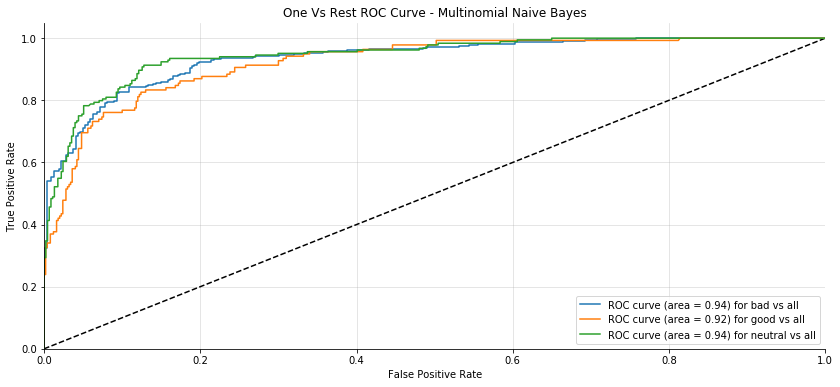

In [320]:
clf = OneVsRestClassifier(MultinomialNB(alpha=.01))
y_score = clf.fit(X_train_tfiddy,ytrain_bin).predict_proba(X_test_tfiddy)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig, ax = plt.subplots(figsize=(14,6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('One Vs Rest ROC Curve - Multinomial Naive Bayes')
for i in range(3):
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {labels[i]} vs all')
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [159]:
y_score.shape
roc_curve()

(638, 3)

In [107]:
model.predict_proba(X_test_tfiddy)[4]

array([0.27585471, 0.59716769, 0.1269776 ])

In [318]:
y_test.iloc[200]

'good'

In [314]:
model.predict(X_test_tfiddy)[200]

'bad'

In [284]:
df.iloc[[1681,2194]]

,index,id,quoteText,services,title,binding,case,point,privacyRelated,score,tldr,sources,irrelevant,reason,tmp_rating,document,label
1681,920,920,"when you share, post, or upload content that i...",facebook,This service can license user content to third...,True,This service can license user content to third...,bad,NaN,50,The scope of the copyright license granted to ...,NaN,False,True,NaN,The scope of the copyright license granted to ...,bad
2194,4763,4763,You have certain rights around the use of your...,kink-com,You can opt out of targeted advertising,True,You can opt out of targeted advertising,good,NaN,25,Generated through the annotate view,NaN,NaN,NaN,NaN,You have certain rights around the use of your...,good


In [184]:
truegood,trueneutral,truebad,neutral_notgood,neutral_notbad,good_notneutral,good_notbad,bad_notneutral,bad_notgood = 0,0,0,0,0,0,0,0,0

for predicted,actual in zip(y_hat,y_test):
    if predicted == actual:
        if predicted == 'good':
            truegood += 1
        if predicted == 'neutral':
            trueneutral += 1
        if predicted == 'bad':
            truebad += 1
    elif (actual == 'good') & (predicted == 'neutral'):
        good_notneutral += 1
    elif (actual == 'good') & (predicted == 'bad'):
        good_notbad += 1
    elif (actual == 'neutral') & (predicted == 'good'):
        neutral_notgood += 1
    elif (actual == 'neutral') & (predicted == 'bad'):
        neutral_notbad += 1
    elif (actual == 'bad') & (predicted == 'neutral'):
        bad_notneutral += 1
    elif (actual == 'bad') & (predicted == 'good'):
        bad_notgood += 1

In [248]:
actualgood = [truegood,good_notneutral,good_notbad]
actualneutral = [neutral_notgood,trueneutral,neutral_notbad]
actualbad = [bad_notgood,bad_notneutral,truebad]
actualgood
actualbad

[21, 18, 277]

In [221]:
#of course there is libary for this

from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, y_hat)[::-1]
matrix

array([[100,  36,  52],
       [ 65,  35,  44],
       [145,  61,  72]])

(-0.5, 3)

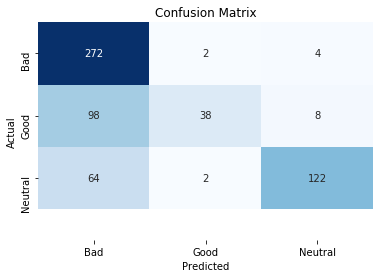

In [240]:
matrix = confusion_matrix(y_test, y_hat)[::-1]
fig,ax = plt.subplots()

sns.heatmap(matrix,annot=True,cbar=False,cmap='Blues', fmt='g')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.xticks([.5,1.5,2.5],labels=['Bad','Good','Neutral'])
plt.yticks([.5,1.5,2.5],labels=['Neutral','Good','Bad'])
plt.ylim(-.5,3)

In [202]:
#Multinomial NB with count vectorizer instead of TFIDF

model = MultinomialNB(alpha=.01)
model.fit(X_train_voncount, y_train)
y_hat = model.predict(X_test_voncount)

model.score(X_test_voncount, y_test)

NameError: name 'X_train_voncount' is not defined

In [230]:
#Complement NB

model = MultinomialNB(alpha=.3)
model.fit(X_train_tfiddy, y_train)
y_hat = model.predict(X_test_tfiddy)

#model.predict_proba(X_test_tfiddy)
model.score(X_test_tfiddy,y_test)

0.7081967213114754

In [241]:
dime = LogisticRegression(solver='lbfgs',C=100,max_iter=200,multi_class='multinomial')
dime.fit(X_train_tfiddy,y_train)
y_dime = dime.predict

In [389]:
y_dime = dime.predict(X_test_tfiddy)
log_prob = dime.predict_proba(X_test_tfiddy)

In [356]:
dime.classes_

array(['bad', 'good', 'neutral'], dtype=object)

In [388]:
tfiddy = TfidfVectorizer(stop_words=cleanest_companies,ngram_range=(1,2))
tfiddy.fit(X_train)
X_train_tfiddy = tfiddy.transform(X_train).toarray()
X_test_tfiddy = tfiddy.transform(X_test).toarray()

model = MultinomialNB(alpha=.02)
model.fit(X_train_tfiddy, y_train)
y_mnb = model.predict(X_test_tfiddy)

model.score(X_test_tfiddy, y_test)

0.7918032786885246

In [358]:
model.classes_

array(['bad', 'good', 'neutral'], dtype='<U7')

In [340]:
a = (mnp_probs + log_prob)/2

In [308]:
a.shape

(610, 3)

In [316]:
np.index_exp()

AttributeError: module 'numpy' has no attribute 'index'

In [365]:
y_pred = model.classes_[arg]

In [304]:
arg = np.argmax(a,axis=1).reshape(610,1)

In [311]:
array = np.full((610,3),fill_value=False)

In [347]:
array[np.arange(len(a)),a.argmax(1)] = True

In [359]:
array

array([[False,  True, False],
       [ True, False, False],
       [False, False,  True],
       ...,
       [False, False,  True],
       [False,  True, False],
       [ True, False, False]])

In [342]:
for num in a:
    if num != np.amax(a,axis=1):
        None
    if num == np.amax(a,axis=1):
        a

array([0.75565618, 0.74074126, 0.80106696, 0.67070722, 0.963055  ,
       0.99982732, 0.94645197, 0.98536801, 0.92908792, 0.59261599,
       0.95458743, 0.53222118, 0.99675206, 0.99820315, 0.98119087,
       0.99737889, 0.99593614, 0.68997705, 0.96696007, 0.89892349,
       0.66650169, 0.99864156, 0.9882842 , 0.99782711, 0.53917807,
       0.89088645, 0.588608  , 0.99185177, 0.43116563, 0.97800964,
       0.82400222, 0.5666323 , 0.99476757, 0.99939677, 0.99154633,
       0.9830405 , 0.92597955, 0.50319881, 0.98563319, 0.79293515,
       0.61354646, 0.99771299, 0.99566412, 0.40515057, 0.71192049,
       0.90883391, 0.49864422, 0.99120142, 0.46676923, 0.66060806,
       0.84760072, 0.89116044, 0.99759876, 0.89866924, 0.97489009,
       0.57445818, 0.99794265, 0.99440111, 0.76872109, 0.99373623,
       0.82996883, 0.74390612, 0.93215958, 0.98708016, 0.99827028,
       0.97394325, 0.992388  , 0.61957782, 0.5487127 , 0.90741484,
       0.76807618, 0.66476721, 0.97544204, 0.88081878, 0.72551

In [248]:
dime.score(X_test_tfiddy,y_test)

0.8229508196721311

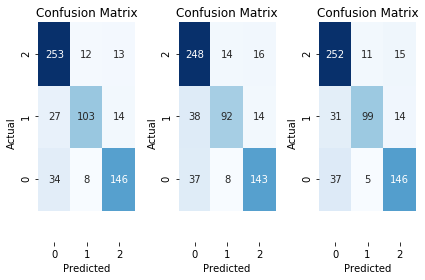

In [391]:
fig,axs = plt.subplots(1,3)

preds = [y_dime,y_mnb,y_pred]

for i,ax in enumerate(axs):
    confusion_matrix(y_test, preds[i])[::-1]
    sns.heatmap(confusion_matrix(y_test, preds[i])[::-1],ax=ax,annot=True,cbar=False,cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_xticks([.5,1.5,2.5])#,labels=['Bad','Good','Neutral'])
    ax.set_yticks([.5,1.5,2.5])#,labels=['Neutral','Good','Bad'])
    ax.set_ylim(-.5,3)

plt.tight_layout()

In [129]:
lostwoods = RandomForestClassifier(n_estimators=1000)
lostwoods.fit(X_train_tfiddy,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
lostwoods.score(X_test_tfiddy,y_test)

0.7540983606557377

In [131]:
clflost = OneVsRestClassifier(RandomForestClassifier(n_estimators=100))
ylost_score = clflost.fit(X_train_tfiddy,ytrain_bin).predict_proba(X_test_tfiddy)

NameError: name 'OneVsRestClassifier' is not defined

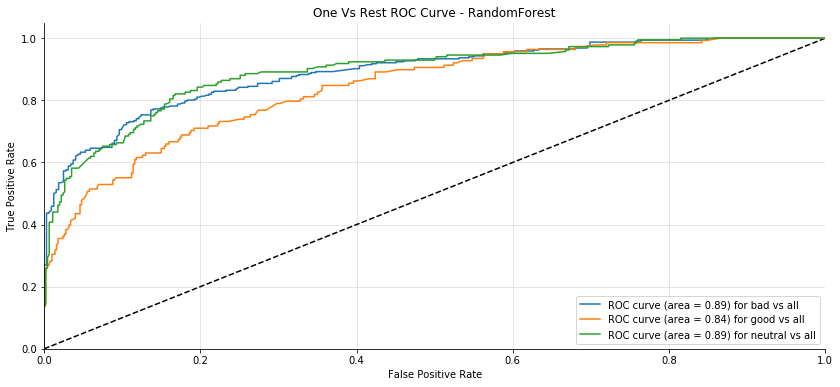

In [319]:
fpr = dict()
tpr = dict()
roc_auc = dict()
labels = ['bad','good','neutral']
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(ytest_bin[:, i], ylost_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fig, ax = plt.subplots(figsize=(14,6))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('One Vs Rest ROC Curve - RandomForest')
for i in range(3):
    ax.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for {labels[i]} vs all')
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
gradientfalls = GradientBoostingClassifier(n_estimators=1000,subsample=0.5)
gradientfalls.fit(X_train_tfiddy,y_train)

In [ ]:
gradientfalls.score(X_test_tfiddy,y_test)
gradientfalls.predict_

In [45]:
feature_log_prob

NameError: name 'feature_log_prob' is not defined

In [72]:
terms_US = '''Users of the Services may be permitted to upload, post or transmit (such as via a stream) or otherwise make available content through the Services including, without limitation, any text, photographs, user videos, sound recordings and the musical works embodied therein, including videos that incorporate locally stored sound recordings from your personal music library and ambient noise (“User Content”). Users of the Services may also extract all or any portion of User Content created by another user to produce additional User Content, including collaborative User Content with other users, that combine and intersperse User Content generated by more than one user. Users of the Services may also overlay music, graphics, stickers, Virtual Items (as defined and further explained Virtual Items Policy) and other elements provided by TikTok (“TikTok Elements”) onto this User Content and transmit this User Content through the Services. The information and materials in the User Content, including User Content that includes TikTok Elements, have not been verified or approved by us. The views expressed by other users on the Services (including through use of the virtual gifts) do not represent our views or values.

Whenever you access or use a feature that allows you to upload or transmit User Content through the Services (including via certain third party social media platforms such as Instagram, Facebook, YouTube, Twitter), or to make contact with other users of the Services, you must comply with the standards set out at “Your Access to and Use of Our Services” above. You may also choose to upload or transmit your User Content, including User Content that includes TikTok Elements, on sites or platforms hosted by third parties. If you decide to do this, you must comply with their content guidelines as well as with the standards set out at “Your Access to and Use of Our Services” above. As noted above, these features may not be available to all users of the Services, and we have no liability to you for limiting your right to certain features of the Services.

You warrant that any such contribution does comply with those standards, and you will be liable to us and indemnify us for any breach of that warranty. This means you will be responsible for any loss or damage we suffer as a result of your breach of warranty.

Any User Content will be considered non-confidential and non-proprietary. You must not post any User Content on or through the Services or transmit to us any User Content that you consider to be confidential or proprietary. When you submit User Content through the Services, you agree and represent that you own that User Content, or you have received all necessary permissions, clearances from, or are authorised by, the owner of any part of the content to submit it to the Services, to transmit it from the Services to other third party platforms, and/or adopt any third party content.

If you only own the rights in and to a sound recording, but not to the underlying musical works embodied in such sound recordings, then you must not post such sound recordings to the Services unless you have all permissions, clearances from, or are authorised by, the owner of any part of the content to submit it to the Services

You or the owner of your User Content still own the copyright in User Content sent to us, but by submitting User Content via the Services, you hereby grant us an unconditional irrevocable, non-exclusive, royalty-free, fully transferable, perpetual worldwide licence to use, modify, adapt, reproduce, make derivative works of, publish and/or transmit, and/or distribute and to authorise other users of the Services and other third-parties to view, access, use, download, modify, adapt, reproduce, make derivative works of, publish and/or transmit your User Content in any format and on any platform, either now known or hereinafter invented.

You further grant us a royalty-free license to use your user name, image, voice, and likeness to identify you as the source of any of your User Content; provided, however, that your ability to provide an image, voice, and likeness may be subject to limitations due to age restrictions.

For the avoidance of doubt, the rights granted in the preceding paragraphs of this Section include, but are not limited to, the right to reproduce sound recordings (and make mechanical reproductions of the musical works embodied in such sound recordings), and publicly perform and communicate to the public sound recordings (and the musical works embodied therein), all on a royalty-free basis. This means that you are granting us the right to use your User Content without the obligation to pay royalties to any third party, including, but not limited to, a sound recording copyright owner (e.g., a record label), a musical work copyright owner (e.g., a music publisher), a performing rights organization (e.g., ASCAP, BMI, SESAC, etc.) (a “PRO”), a sound recording PRO (e.g., SoundExchange), any unions or guilds, and engineers, producers or other royalty participants involved in the creation of User Content.

Specific Rules for Musical Works and for Recording Artists. If you are a composer or author of a musical work and are affiliated with a PRO, then you must notify your PRO of the royalty-free license you grant through these Terms in your User Content to us. You are solely responsible for ensuring your compliance with the relevant PRO’s reporting obligations. If you have assigned your rights to a music publisher, then you must obtain the consent of such music publisher to grant the royalty-free license(s) set forth in these Terms in your User Content or have such music publisher enter into these Terms with us. Just because you authored a musical work (e.g., wrote a song) does not mean you have the right to grant us the licenses in these Terms. If you are a recording artist under contract with a record label, then you are solely responsible for ensuring that your use of the Services is in compliance with any contractual obligations you may have to your record label, including if you create any new recordings through the Services that may be claimed by your label.

Through-To-The-Audience Rights. All of the rights you grant in your User Content in these Terms are provided on a through-to-the-audience basis, meaning the owners or operators of third party services will not have any separate liability to you or any other third party for User Content posted or used on such third party service via the Services.

Waiver of Rights to User Content. By posting User Content to or through the Services, you waive any rights to prior inspection or approval of any marketing or promotional materials related to such User Content. You also waive any and all rights of privacy, publicity, or any other rights of a similar nature in connection with your User Content, or any portion thereof. To the extent any moral rights are not transferable or assignable, you hereby waive and agree never to assert any and all moral rights, or to support, maintain or permit any action based on any moral rights that you may have in or with respect to any User Content you Post to or through the Services.

We also have the right to disclose your identity to any third party who is claiming that any User Content posted or uploaded by you to our Services constitutes a violation of their intellectual property rights, or of their right to privacy.

We, or authorised third parties, reserve the right to cut, crop, edit or refuse to publish, your content at our or their sole discretion. We have the right to remove, disallow, block or delete any posting you make on our Services if, in our opinion, your post does not comply with the content standards set out at “Your Access to and Use of Our Services”above. In addition, we have the right – but not the obligation – in our sole discretion to remove, disallow, block or delete any User Content (i) that we consider to violate these Terms, or (ii) in response to complaints from other users or third parties, with or without notice and without any liability to you. As a result, we recommend that you save copies of any User Content that you post to the Services on your personal device(s) in the event that you want to ensure that you have permanent access to copies of such User Content. We do not guarantee the accuracy, integrity, appropriateness or quality of any User Content, and under no circumstances will we be liable in any way for any User Content.

You control whether your User Content is made publicly available on the Services to all other users of the Services or only available to people you approve. To restrict access to your User Content, you should select the privacy setting available within the Platform.

We accept no liability in respect of any content submitted by users and published by us or by authorised third parties.

If you wish to complain about information and materials uploaded by other users please contact us at: feedback@tiktok.com.

TikTok takes reasonable measures to expeditiously remove from our Services any infringing material that we become aware of.It is TikTok’s policy, in appropriate circumstances and at its discretion, to disable or terminate the accounts of users of the Services who repeatedly infringe copyrights or intellectual property rights of others.

While our own staff is continually working to develop and evaluate our own product ideas and features, we pride ourselves on paying close attention to the interests, feedback, comments, and suggestions we receive from the user community. If you choose to contribute by sending us or our employees any ideas for products, services, features, modifications, enhancements, content, refinements, technologies, content offerings (such as audio, visual, games, or other types of content), promotions, strategies, or product/feature names, or any related documentation, artwork, computer code, diagrams, or other materials (collectively “Feedback”), then regardless of what your accompanying communication may say, the following terms will apply, so that future misunderstandings can be avoided. Accordingly, by sending Feedback to us, you agree that:

TikTok has no obligation to review, consider, or implement your Feedback, or to return to you all or part of any Feedback for any reason;

Feedback is provided on a non-confidential basis, and we are not under any obligation to keep any Feedback you send confidential or to refrain from using or disclosing it in any way; and

You irrevocably grant us perpetual and unlimited permission to reproduce, distribute, create derivative works of, modify, publicly perform (including on a through-to-the-audience basis), communicate to the public, make available, publicly display, and otherwise use and exploit the Feedback and derivatives thereof for any purpose and without restriction, free of charge and without attribution of any kind, including by making, using, selling, offering for sale, importing, and promoting commercial products and services that incorporate or embody Feedback, whether in whole or in part, and whether as provided or as modified.'''

In [73]:
terms_EU = '''    Users of the Services may be permitted to upload, post or transmit (such as via a stream) or otherwise make available content through the Services including, without limitation, any text, photographs, user videos, sound recordings and the musical works embodied therein, including videos that incorporate locally stored sound recordings from your personal music library and ambient noise (“User Content”). Users of the Services may also extract all or any portion of User Content created by another user to produce additional User Content, including collaborative User Content with other users, that combine and intersperse User Content generated by more than one user. Users of the Services may also overlay music, graphics, stickers, Virtual Items (as defined and further explained in the “VIRTUAL ITEMS POLICY “) and other elements provided by TikTok (“TikTok Elements”) onto this User Content and transmit this User Content through the Services. The information and materials in the User Content, including User Content that includes TikTok Elements, have not been verified or approved by us. The views expressed by other users on the Services (including through use of the virtual gifts) do not represent our views or values.

    Whenever you access or use a feature that allows you to upload or transmit User Content through the Services (including via certain third party social media platforms such as Instagram, Facebook, YouTube, Twitter), or to make contact with other users of the Services, you must comply with the standards set out at Section 5 above. You may also choose to upload or transmit your User Content, including User Content that includes TikTok Elements, on sites or platforms hosted by third parties. If you decide to do this, you must comply with their content guidelines as well as with the standards set out in this Section 7 above.

    You warrant that any such contribution does comply with those standards, and you will be liable to us and indemnify us for any breach of that warranty. This means you will be responsible for any loss or damage we suffer as a result of your breach of warranty.

    Any User Content will be considered non-confidential and non-proprietary. You must not post any User Content on or through the Services or transmit to us any User Content that you consider to be confidential or proprietary. When you submit User Content through the Services, you agree and represent that you own that User Content, or you have received all necessary permissions, clearances from, or are authorised by, the owner of any part of the content to submit it to the Services, to transmit it from the Services to other third party platforms, and/or adopt any third party content.

    If you only own the rights in and to a sound recording, but not to the underlying musical works embodied in such sound recordings, then you must not post such sound recordings to the Services unless you have all permissions, clearances from, or are authorised by, the owner of any part of the content to submit it to the Services .

    You or the owner of your User Content still own the copyright in User Content sent to us, but by submitting User Content via the Services, you hereby grant us an unconditional irrevocable, non-exclusive, royalty-free, fully transferable, perpetual worldwide licence to use, modify, adapt, reproduce, make derivative works of, publish and/or transmit, and/or distribute and to authorise others users of the Services and other third-parties to view, access, use, download, modify, adapt, reproduce, make derivative works of, publish and/or transmit your User Content in any format and on any platform, either now known or hereinafter invented.

    You further grant us a royalty-free license to use your user name, image, voice, and likeness to identify you as the source of any of your User Content.

    For the avoidance of doubt, the rights granted in the preceding paragraphs of this Section include, but are not limited to, the right to reproduce sound recordings (and make mechanical reproductions of the musical works embodied in such sound recordings), and publicly perform and communicate to the public sound recordings (and the musical works embodied therein), all on a royalty-free basis. This means that you are granting us the right to Use your User Content without the obligation to pay royalties to any third party, including, but not limited to, a sound recording copyright owner ( e.g. , a record label), a musical work copyright owner ( e.g. , a music publisher), a performing rights organization ( e.g. , ASCAP, BMI, SESAC, etc.) (a “ PRO ”), a sound recording PRO (e.g., SoundExchange), any unions or guilds, and engineers, producers or other royalty participants involved in the creation of User Content.

Specific Rules for Musical Works and for Recording Artists. If you are a composer or author of a musical work and are affiliated with a [PRO], then you must notify your PRO of the royalty-free license you grant through these Terms in your User Content to us. You are solely responsible for ensuring your compliance with the relevant PRO’s reporting obligations. If you have assigned your rights to a music publisher, then you must obtain the consent of such music publisher to grant the royalty-free license(s) set forth in these Terms in your User Content or have such music publisher enter into these Terms with us. Just because you authored a musical work (e.g., wrote a song) does not mean you have the right to grant us the licenses in these Terms. If you are a recording artist under contract with a record label, then you are solely responsible for ensuring that your use of the Services is in compliance with any contractual obligations you may have to your record label, including if you create any new recordings through the Services that may be claimed by your label.

Through-To-The-Audience Rights. All of the rights you grant in your User Content in these Terms are provided on a through-to-the-audience basis, meaning the owners or operators of third party services will not have any separate liability to you or any other third party for User Content posted or used on such third party service via the Services.

Waiver of Rights to User Content. By posting User Content to or through the Services, you waive any rights to prior inspection or approval of any marketing or promotional materials related to such User Content. You also waive any and all rights of privacy, publicity, or any other rights of a similar nature in connection with your User Content, or any portion thereof. To the extent any moral rights are not transferable or assignable, you hereby waive and agree never to assert any and all moral rights, or to support, maintain or permit any action based on any moral rights that you may have in or with respect to any User Content you Post to or through the Services.

In certain circumstances, we also have the right to disclose your identity to any third party who is claiming that any User Content posted or uploaded by you to our Services constitutes a violation of their intellectual property rights, or of their right to privacy.

We, or authorised third parties, reserve the right to cut, crop, edit or refuse to publish, your content at our or their sole discretion. We have the right to remove, disallow, block or delete any posting you make on our Platform if, in our opinion, your post does not comply with the content standards set out at Section 5 (Your Use of Our Services) above. In addition, we have the right – but not the obligation – in our sole discretion to remove, disallow, block or delete any User Content (i) that we consider to violate these Terms, or (ii) in response to complaints from other users or third parties, with or without notice and without any liability to you. As a result, we recommend that you save copies of any User Content that you post to the Services on your personal device(s) in the event that you want to ensure that you have permanent access to copies of such User Content. We do not guarantee the accuracy, integrity, appropriateness or quality of any User Content, and under no circumstances will we be liable in any way for any User Content.

You control whether your User Content is made publicly available on the Services to all other users of the Services or only available to people you approve. To change the default access setting for how your User Content is made available to other users, you should select the privacy setting available within the Apps.

We accept no liability in respect of any content submitted by users and published by us or by authorised third parties.

If you wish to complain about information and materials uploaded by other users, please contact us at reports@tiktok.com. 

TikTok takes reasonable measures to expeditiously remove from our Services any infringing material that we become aware of. It is TikTok’s policy, in appropriate circumstances and at its discretion, to disable or terminate the accounts of users of the Services who repeatedly infringe copyrights or intellectual property rights of others.

While our own staff is continually working to develop and evaluate our own product ideas and features, we pride ourselves on paying close attention to the interests, feedback, comments, and suggestions we receive from the user community. If you choose to contribute by sending us or our employees any ideas for products, services, features, modifications, enhancements, content, refinements, technologies, content offerings (such as audio, visual, games, or other types of content), promotions, strategies, or product/feature names, or any related documentation, artwork, computer code, diagrams, or other materials (collectively “Feedback”), then regardless of what your accompanying communication may say, the following terms will apply, so that future misunderstandings can be avoided. Accordingly, by sending Feedback to us, you agree that:

    we have no obligation to review, consider, or implement your Feedback, or to return to you all or part of any Feedback for any reason;

    Feedback is provided on a non-confidential basis, and we are not under any obligation to keep any Feedback you send confidential or to refrain from using or disclosing it in any way;

    and You irrevocably grant us perpetual and unlimited permission to reproduce, distribute, create derivative works of, modify, publicly perform (including on a through-to-the-audience basis), communicate to the public, make available, publicly display, and otherwise use and exploit the Feedback and derivatives thereof for any purpose and without restriction, free of charge and without attribution of any kind, including by making, using, selling, offering for sale, importing, and promoting commercial products and services that incorporate or embody Feedback, whether in whole or in part, and whether as provided or as modified.'''

In [7]:
len(terms_US)

11187

In [8]:
len(terms_EU)

10938

In [201]:
terms_US = terms_US.split('\n')
terms_US = [term for term in terms_US if term != '']

AttributeError: 'list' object has no attribute 'split'

In [205]:
terms_EU = terms_EU.split('\n')

AttributeError: 'list' object has no attribute 'split'

In [76]:
terms_EU = [term for term in terms_EU if term != '']

In [206]:
import pickle
tfidf_model = pickle.load(open('apps/tfidf.sav','rb'))
loaded_model = pickle.load(open('apps/model.sav', 'rb'))
#input_vectorized = tfidf_model.transform(pd.Series(term)).toarray()
#classification = str(loaded_model.predict(input_vectorized))

In [207]:
classification_US = []

for term in terms_US:
    classification_US.append(str(loaded_model.predict(tfidf_model.transform(pd.Series(term)).toarray())))

NotFittedError: This MultinomialNB instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [140]:
classification_EU = []

for term in terms_EU:
    classification_EU.append(str(loaded_model.predict(tfidf_model.transform(pd.Series(term)).toarray())))

In [141]:
pd.DataFrame([classification_US,classification_EU],index=['US','EU']).T

,US,EU
0,['bad'],['bad']
1,['bad'],['bad']
2,['bad'],['bad']
3,['bad'],['bad']
4,['bad'],['bad']
5,['bad'],['bad']
6,['bad'],['bad']
7,['bad'],['bad']
8,['bad'],['bad']
9,['bad'],['bad']
